### We saw that with random classification, we always hit an error floor of around 10%. This could simply be because we use non-overlapping windows to segment our dataset. Some segments labeled as signal will have a lot more noise than the signal. Let's add a forgetting filter to our weights to see if it will mitigate that problem.

In [5]:
import numpy as np
from data_fns import noisy_sin_signal, data_matrix, butter_bandpass_filter
from estimator import RFClassifier, relu, sigmoid
import dask
import matplotlib.pyplot as plt

In [58]:
from dask.distributed import Client
client = Client(threads_per_worker=7, n_workers=10)
client

Client Scheduler: tcp://127.0.0.1:39283 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 70 Memory: 135.06 GB


In [6]:
def bp_weights(M, N, lowcut, highcut, fs, seed=None):
    if seed is not None:
        np.random.seed(seed)
    J = np.random.randn(M, N)
    J = butter_bandpass_filter(J, lowcut, highcut, fs)
    return J.T

def forget_filter(t, gamma, f_s, t_memory):
    t_points = np.arange(t * f_s)
    n_memory = int(f_s * t_memory)
    f = np.minimum(1, gamma ** -(t_points - n_memory))
    return f[::-1].reshape(-1, 1)

def l_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

__Let's visualize the forgetting weights.__

$$
filter = \min(1, \gamma^{t - t_{memory}}) \\
\text{weights} = \text{normal weights} * filter
$$

(array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 11 Text yticklabel objects>)

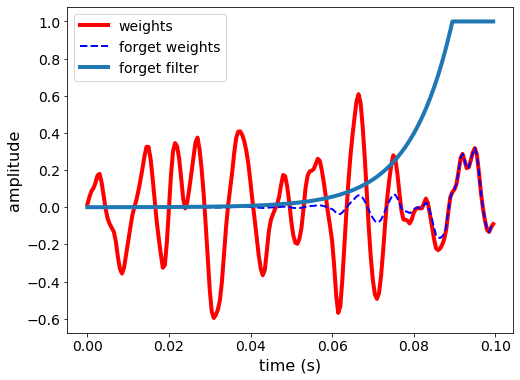

In [107]:
# visualize forgetting weights
mem = 0.01
weights = lambda M, N: bp_weights(M, N, 50, 120, fs, seed=10)
f_weights = lambda M, N: weights(M, N) * forget_filter(delta, 1.05, fs, mem)

n = 5
t = np.arange(0, N) / fs
fig = plt.figure(figsize=(8, 6))
plt.plot(t, weights(20, N).T[n], 'r', label='weights', lw=4)
plt.plot(t, f_weights(20, N).T[n], '--b', label='forget weights', lw=2)
plt.plot(t, forget_filter(delta, 1.05, fs, mem), label='forget filter', lw=4)
plt.xlabel('time (s)', fontsize=16)
plt.ylabel('amplitude', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig('figures/forget_filter/forget_weights.png')

In [120]:
# generate data
fs, dur, sig_dur, f_signal = 2000, 10, 0.05, 80
a = 0.5
signal, label = noisy_sin_signal(f_s=fs, dur=dur, sig_dur=sig_dur, f_signal=f_signal, a=a)

delta = 0.1
N = int(delta * fs)
X, y = data_matrix(signal, label, N)

idx = int(len(X) * 2 / 3)
X_train, y_train = X[:idx], y[:idx]
X_test, y_test = X[idx:], y[idx:]

In [121]:
n_features = sorted(set(np.logspace(0, 3, 20).astype('int')))
print(n_features)

[1, 2, 4, 6, 8, 12, 18, 26, 37, 54, 78, 112, 162, 233, 335, 483, 695, 1000]


__Let's change the length of the region of perfect memory and see how performance changes.__

In [122]:
%%time
# effect of forgetting on performance
weights = lambda M, N: bp_weights(M, N, 50, 120, fs)

neuron_memory = [0, delta / 4, delta * 2 / 3, delta]

results = []
for mem in neuron_memory:
    f_weights = lambda M, N: weights(M, N) * forget_filter(delta, 1.05, fs, mem)
    mem_results = []
    for n in n_features:
        print(mem, n)
        params = {'width': n, 'weights': 'bandpass', 'nonlinearity': relu, 'weight_fun': f_weights}
        lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(5)]
        mem_results.append(dask.compute(*lazy_results))
    results.append(mem_results)

mean_results = 1 - np.mean(results, axis=2)
std_results = np.std(results, axis=2)

0 1
0 2
0 4
0 6
0 8
0 12
0 18
0 26
0 37
0 54
0 78
0 112
0 162
0 233
0 335
0 483
0 695
0 1000
0.025 1
0.025 2
0.025 4
0.025 6
0.025 8
0.025 12
0.025 18
0.025 26
0.025 37
0.025 54
0.025 78
0.025 112
0.025 162
0.025 233
0.025 335
0.025 483
0.025 695
0.025 1000
0.06666666666666667 1
0.06666666666666667 2
0.06666666666666667 4
0.06666666666666667 6
0.06666666666666667 8
0.06666666666666667 12
0.06666666666666667 18
0.06666666666666667 26
0.06666666666666667 37
0.06666666666666667 54
0.06666666666666667 78
0.06666666666666667 112
0.06666666666666667 162
0.06666666666666667 233
0.06666666666666667 335
0.06666666666666667 483
0.06666666666666667 695
0.06666666666666667 1000
0.1 1
0.1 2
0.1 4
0.1 6
0.1 8
0.1 12
0.1 18
0.1 26
0.1 37
0.1 54
0.1 78
0.1 112
0.1 162
0.1 233
0.1 335
0.1 483
0.1 695
0.1 1000
CPU times: user 1min 32s, sys: 41.1 s, total: 2min 13s
Wall time: 9min 39s


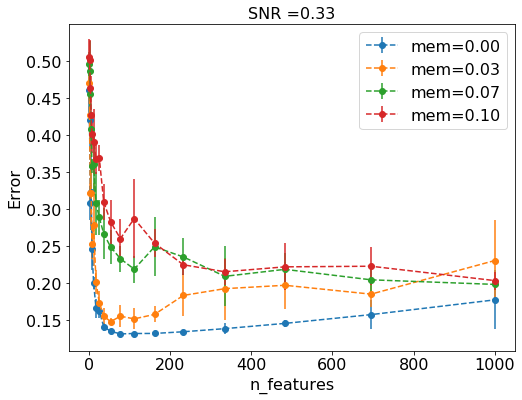

In [124]:
snr = a ** 2 / (1 - a ** 2)
fig = plt.figure(figsize=(8, 6))
plt.title('SNR =%0.2f' % (snr), fontsize=16)
for i, mem in enumerate(neuron_memory):
    plt.errorbar(n_features, mean_results[i], yerr=std_results[i], fmt='--o', label=r'mem=%0.2f' % mem)
plt.xlabel('n_features', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('figures/forget_filter/forget_clf_a=%0.2f.png' % a)

# plt.xlim(0, 100)
# plt.savefig('figures/forget_filter/forget_clf_a=%0.2f_zoomed.png' % a)

__Comment__: We see that forgeting improves performance by a lot. Interestingly, having imperfect memory gives the best performance.